# Time Series

In [1]:
%matplotlib inline

In [2]:
import scipy
import numpy
import pandas
import seaborn
from datetime import datetime
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose

/home/podondra/mi-pdd/venv/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
seaborn.set()
seaborn.set_style('ticks')

## Data

In [4]:
train_file = 'data/train.csv'
test_file = 'data/test.csv'

# last column contains the class
train = numpy.genfromtxt('data/train.csv', delimiter='\t')
test = numpy.genfromtxt('data/test.csv', delimiter='\t')
X, y = train[:, :-1], train[:, -1].astype(numpy.int8)
X_te, y_te = test[:, :-1], test[:, -1].astype(numpy.int8)
X.shape, y.shape

((300, 60), (300,))

There is 6 classes each with 50 sample in both train and test set.

In [5]:
numpy.unique(y, return_counts=True)

(array([1, 2, 3, 4, 5, 6], dtype=int8), array([50, 50, 50, 50, 50, 50]))

In [6]:
numpy.unique(y_te, return_counts=True)

(array([1, 2, 3, 4, 5, 6], dtype=int8), array([50, 50, 50, 50, 50, 50]))

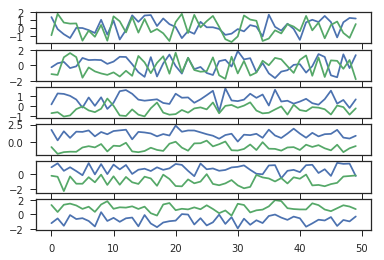

In [7]:
f, axs = pyplot.subplots(nrows=6)
for i, ax in enumerate(axs):
    ax.plot(X[y == i + 1][:, numpy.random.randint(0, 49, size=2)])

## Dynamic Time Warping

https://github.com/alexminnaar/time-series-classification-and-clustering

Dynamic time warping finds the optimal non-linear alignment between two time series.
The aligment on the time axis fixes the distortions that cannot be captured when comparing coefficients having the same index (as many metrics do).
Dynamic time warping is quadratic in the length of the time series used.

Dynamic time warping works in the following way.
Consider two time series $Q = q_1, q_2, \dots, q_n$ and $C = c_1, c_2, \dots, c_n$ of the same length $n$ where
We construct an $n \times n$ matrix $M$ whose $i, j$ element is the (Euclidean) distance between $q_i$ and $c_j$.
We want to find a path through this matrix that minimizes the cumulative distance.
This path then determines the optimal alignment between the two time series.
Of course, we restrict ourselves to path that have non-decreasing indices and have fixed starting end ending points.

The optimal path is usually found via dynamic programming, specifically the following recursive function:

$$\gamma(i, j) = \mathrm{d}(q_i, c_j) + \min(\gamma(i - 1, j - 1), \gamma(i - 1, j), \gamma(i, j - 1))$$

where $\mathrm{d}$ is some distance.

We can improve the DTW distance by adding another restriction for the path.
We require the path to be close the diagonal of $M$.
The closeness is given by the width $w$ of the stripe along the diagonal that is to contain the optimal path.
In other words, we give a limit on the maximal possible time distortion that DTW can capture.

In [8]:
def DTWDistance(s1, s2, w):
    DTW = {}
    
    w = max(w, abs(len(s1) - len(s2)))
    
    for i in range(-1,len(s1)):
        for j in range(-1, len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0
  
    for i in range(len(s1)):
        for j in range(max(0, i - w), min(len(s2), i + w)):
            dist = (s1[i] - s2[j]) ** 2
            DTW[(i, j)] = dist + min(DTW[(i - 1, j)], DTW[(i, j - 1)], DTW[(i - 1, j - 1)])

    return numpy.sqrt(DTW[len(s1) - 1, len(s2) - 1])

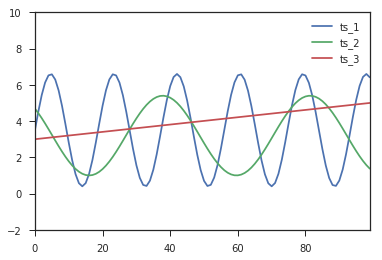

In [9]:
# sample data
x = numpy.linspace(0, 50, 100)
ts_1 = pandas.Series(3.1 * numpy.sin(x / 1.5) + 3.5)
ts_2 = pandas.Series(2.2 * numpy.sin(x / 3.5 + 2.4) + 3.2)
ts_3 = pandas.Series(0.04 * x + 3.0)

ts_1.plot()
ts_2.plot()
ts_3.plot()
pyplot.ylim(-2, 10)
pyplot.legend(['ts_1','ts_2','ts_3'])

In [10]:
DTWDistance(ts_1, ts_1, 5), DTWDistance(ts_1, ts_2, 5), DTWDistance(ts_1, ts_3, 5)

(0.0, 21.325435982766471, 22.688332647362234)

### LB Keogh

Another similarity measure requires to build an envolepe around the base series and then test whether the tested signal falls well into this envelope.

The distance from the envelope is given by the following the LB Keogh lower bound of dynamic time warping.
It is defined as:

$$LBKeogh(Q, C) = \sum_{i = 1}^n (c_i - U_i) ^ 2I(c_i > U_i) + (c_i - L_i)^2 I(c_i < L_i)$$

where $U_i$ and $L_i$ are upper and lower bounds for time series $Q$
which are defined as $U_i = max(q_{i - r}, q_{i + r})$
and $L_i = min(q_{i - r}, q_{i + r})$ for a reach $r$ and $I(\cdot)$ is the indicator function.

Its name comes from the fact that it was originally conceived as a cheaper indicator for the DTW metric,
having this property:

$$LBKeogh(Q, C) \leq DTW(Q, C)$$

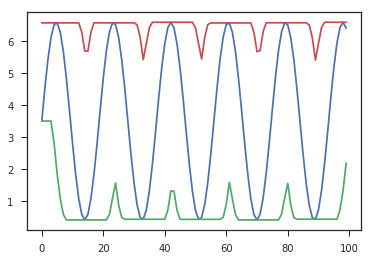

In [11]:
r = 7
# lower bound for the envelope
L = [min(ts_1[idx - r if idx - r >= 0 else 0:idx + r]) for idx in range(len(ts_1))]
# upper bound for the envelope
U = [max(ts_1[idx - r if idx - r >= 0 else 0:idx + r]) for idx in range(len(ts_1))]

pyplot.plot(ts_1)
pyplot.plot(ts_1.index, L)
pyplot.plot(ts_1.index, U)

In [12]:
def LB_Keogh(s1, s2, r):
    LB_sum = 0
    for idx, i in enumerate(s1):
        lower_bound = min(s2[idx - r if idx - r >= 0 else 0:idx + r])
        upper_bound = max(s2[idx - r if idx - r >= 0 else 0:idx + r])
        
        if i > upper_bound:
            LB_sum = LB_sum + (i - upper_bound) ** 2
        elif i < lower_bound:
            LB_sum = LB_sum + (i - lower_bound) ** 2

    return numpy.sqrt(LB_sum)

In [13]:
LB_Keogh(ts_1, ts_1, 5), LB_Keogh(ts_1, ts_2, 5), LB_Keogh(ts_1, ts_3, 5)

(0.0, 18.699672203819983, 22.390567805772839)

## Performance

Perform some experiments to obtain an idea the performance of `DTWDistance` and `LB_Keogh` similarity measures
on `test` and `train` data using the provided class information.
In other words, try to aswer the question
if one of the distances could be used for sucessful clustering of `train` and/or for classification of `test`?

## Wedge

For each class of `train`, construct its wedge (from the lecture) and use it as the envelope bounds $U$ and $L$ for a redefied `LB_Keogh` distance. Use this distance on the `test` and try to classify its elements and report on the performance of the classification (sucess percentage and confusion matrix).

## Clustering (Optional)

Perform a clustering method of your choice on `train` and compare the obtained cluster with the provided class information.